In [26]:
from tic_tac_toe import TicTacToe
from gym import make

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from collections import deque, namedtuple
import random
import copy
import matplotlib.pyplot as plt


%matplotlib inline
plt.style.use('ggplot')
from IPython.display import clear_output
import matplotlib
from collections import defaultdict
from abc import ABC, abstractmethod
import math

random.seed(0)

# Часть первая: крестики-нолики при помощи Q-обучения #
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.





In [2]:
class QLearning():
    def __init__(self, env, lr=0.95, gamma=0.99, n_iter=1000,
                        info_freq=40000, action_space=9):
        self.lr = lr
        self.gamma = gamma
        self.n_iter = n_iter
        self.info_freq = info_freq
        self.Q = defaultdict(lambda: np.zeros(action_space))
        self.mean_rewards = []
        self.env = env

    def act(self, state):
        available_actions = self.env.getEmptySpaces()
        num_available_actions = len(available_actions) 
        action_idx = int(np.argmax(self.Q[state]))
        action = self.env.action_from_int(action_idx) 
        q_value = self.Q[state][action_idx]        
        return q_value, action, action_idx

    def train(self):
        done = 0
        episode_reward = 0
        self.env.reset()
        init_state = self.env.getHash()
        cur_mean_reward = 0

        for iter_num in range(self.n_iter):            
            while not done:
                q_value, action, action_idx = self.act(init_state)

                new_state, reward, done, info = self.env.step(action)
                episode_reward = episode_reward + reward

                new_state = new_state[0]
                next_q_value, _, _ = self.act(new_state)
                self.Q[init_state][action_idx] = (1 - self.lr) * q_value + self.lr * (reward + self.gamma * next_q_value)

                init_state = new_state

            cur_mean_reward = (iter_num * cur_mean_reward + episode_reward) / (iter_num + 1)
            self.mean_rewards.append(cur_mean_reward)
            init_state = self.env.reset()
            done = 0
            episode_reward = 0

            if (iter_num % self.info_freq) == 0:
                print(f'Average reward at iteration {iter_num}: {cur_mean_reward}')

In [6]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
q_learning_model = QLearning(env=env, n_iter=200001, info_freq=20000, action_space=9)

q_learning_model.train()

Average reward at iteration 0: -10.0
Average reward at iteration 20000: 0.9884505774711264
Average reward at iteration 40000: 0.9942251443713905
Average reward at iteration 60000: 0.9961500641655971
Average reward at iteration 80000: 0.9971125360932989
Average reward at iteration 100000: 0.997690023099769
Average reward at iteration 120000: 0.998075016041533
Average reward at iteration 140000: 0.9983500117856301
Average reward at iteration 160000: 0.9985562590233811
Average reward at iteration 180000: 0.9987166737962567
Average reward at iteration 200000: 0.9988450057749712


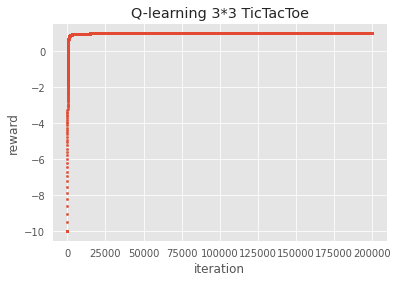

In [7]:
def show_rewards(avg_rewards):
    iterations=np.arange(0, len(avg_rewards))
    fig, ax = plt.subplots(1, 1)
    ax.scatter(iterations, avg_rewards, s=5)
    ax.set_xlabel('iteration')
    ax.set_ylabel('reward')
    _ = ax.set_title('Q-learning 3*3 TicTacToe')

show_rewards(q_learning_model.mean_rewards)

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Была использована доска 4x4.

Гораздо медленнее, но все так же обучается.

In [8]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
q_learning_model = QLearning(env=env, n_iter=200001, info_freq=20000, action_space=16)

q_learning_model.train()

Average reward at iteration 0: -10.0
Average reward at iteration 20000: 0.9571021448927561
Average reward at iteration 40000: 0.978550536236594
Average reward at iteration 60000: 0.9857002383293612
Average reward at iteration 80000: 0.9892751340608245
Average reward at iteration 100000: 0.9914200857991422
Average reward at iteration 120000: 0.9928500595828369
Average reward at iteration 140000: 0.9938714723466261
Average reward at iteration 160000: 0.9946375335154155
Average reward at iteration 180000: 0.9952333598146677
Average reward at iteration 200000: 0.9957100214498927


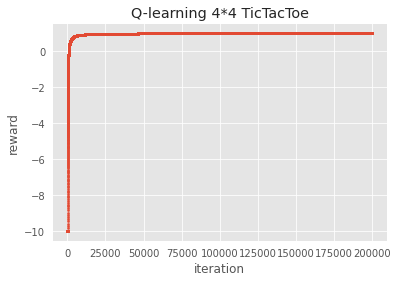

In [9]:
def show_rewards(avg_rewards):
    iterations=np.arange(0, len(avg_rewards))
    fig, ax = plt.subplots(1, 1)
    ax.scatter(iterations, avg_rewards, s=5)
    ax.set_xlabel('iteration')
    ax.set_ylabel('reward')
    _ = ax.set_title('Q-learning 4*4 TicTacToe')

show_rewards(q_learning_model.mean_rewards)

# Часть вторая: добавим нейронных сетей #
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).


1. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

Основано на ДЗ курса Practical RL (MADE), https://github.com/ArgentumWalker/MADE-Practical-RL-homework-2021/tree/main/hw01_lunar_lander


Работает нестабильно (средняя награда скачет), что согласуется с теорией. Обучается долго.

In [10]:
GAMMA = 0.99
INITIAL_STEPS = 1024
TRANSITIONS = 1200000
STEPS_PER_UPDATE = 4
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000
BATCH_SIZE = 64
LEARNING_RATE = 5e-4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ExpirienceReplay:
    def __init__(self, size=100000, seed=0):
        self.data = deque(maxlen=size)
        self.seed = random.seed(seed)        
    
    def add(self, transition):        
        self.data.append(transition)
        
    def sample(self, size):
        batch = random.sample(self.data, size)
        states = torch.from_numpy(np.vstack([e.state for e in batch if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in batch if e is not None])).long().to(device)        
        next_states = torch.from_numpy(np.vstack([e.next_state for e in batch if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in batch if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in batch if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)


class DQNModel(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(DQNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, x):
        return self.main(x)


class DQN:
    def __init__(self, state_dim, action_dim, batch_size=BATCH_SIZE, seed=0):
        self.steps = 0 # Do not change        
        self.buffer = ExpirienceReplay()
        self.batch_size = batch_size        
        self.seed = random.seed(seed)
        
        self.model = DQNModel(state_dim, 64, action_dim)
        self.optimizer = Adam(self.model.parameters())

    def consume_transition(self, transition):        
        self.buffer.add(transition)

    def sample_batch(self):
        return self.buffer.sample(self.batch_size)
        
    def train_step(self, batch):
        states, actions, rewards, next_states, dones = batch
        # Get the action with max Q value
        action_values = self.model(next_states).detach()
        # Notes
        # tensor.max(1)[0] returns the values, tensor.max(1)[1] will return indices
        # unsqueeze operation --> np.reshape
        # Here, we make it from torch.Size([64]) -> torch.Size([64, 1])
        max_action_values = action_values.max(1)[0].unsqueeze(1)
        
        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (GAMMA * max_action_values * (1 - dones))
        Q_expected = self.model(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()


    def act(self, state):
        # Compute an action. Do not forget to turn state to a Tensor and then turn an action to a numpy array.
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.model.eval()
        with torch.no_grad():
            action_values = self.model(state)
        self.model.train()
        return np.argmax(action_values.cpu().data.numpy())        
    
        
    def update(self, transition):
        # You don't need to change this
        self.consume_transition(transition)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
        self.steps += 1

    def save(self):
        torch.save(self.model.state_dict(), "agent.pkl")

def state_to_array(state_str):
    return np.array([int(s) for s in state_str])

def sample_action(env):
    actions = env.getEmptySpaces()
    empty_spots_count = len(actions)
    picked_action = actions[np.random.randint(0, empty_spots_count)]
    action_idx = env.int_from_action(picked_action)
    return picked_action, action_idx    

def evaluate_policy(agent, env, episodes=5):
    returns = []
    for _ in range(episodes):
        done = False
        env.reset()
        state = state_to_array(env.getHash())
        total_reward = 0.1
        
        while not done:
            state, reward, done, _ = env.step(env.action_from_int(agent.act(state)))
            state = state_to_array(state[0])
            total_reward += reward
        returns.append(total_reward)
    return returns

In [14]:
def train_dqn():
    env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
    eps = 0.01
    env.reset()
    dqn = DQN(state_dim=4*4, action_dim=4*4)
    state = state_to_array(env.getHash())
    total_rewards = []


    for _ in range(INITIAL_STEPS):
        # action = env.action_space.sample()
        picked_action, action_idx = sample_action(env)

        # next_state, reward, done, _ = env.step(action)
        next_state, reward, done, _ = env.step(picked_action)
        
        next_state = state_to_array(next_state[0])
        
        dqn.consume_transition(Transition(state, action_idx, next_state, reward, done)  )
          
        if not done:
            state = next_state 
        else:
            env.reset()
            state = state_to_array(env.getHash())
        

    for i in range(TRANSITIONS):
        #Epsilon-greedy policy
        if random.random() < eps:
            action, action_idx = sample_action(env)
        else:
            action_idx = dqn.act(state)
            action = env.action_from_int(action_idx)

        next_state, reward, done, _ = env.step(action)
        next_state = state_to_array(next_state[0])
        dqn.update(Transition(state, action_idx, next_state, reward, done))
        
        if not done:
            state = next_state 
        else:
            env.reset()
            state = state_to_array(env.getHash())
        
        if (i + 1) % (TRANSITIONS//50) == 0:
            rewards = evaluate_policy(dqn, env, 30)
            total_rewards.append(np.mean(rewards))
            print(f"Step: {i+1}, Reward mean: {np.mean(rewards)}, Reward std: {np.std(rewards)}")
    return total_rewards

In [15]:
rewards = train_dqn()

Step: 24000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 48000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 72000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 96000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 120000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 144000, Reward mean: -0.8999999999999998, Reward std: 2.220446049250313e-16
Step: 168000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16
Step: 192000, Reward mean: 0.10000000000000003, Reward std: 2.7755575615628914e-17
Step: 216000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16
Step: 240000, Reward mean: 0.10000000000000003, Reward std: 2.7755575615628914e-17
Step: 264000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 288000, Reward mean: -0.8999999999999998, Reward std: 2.220446049250313e-16
Step: 312000, Reward

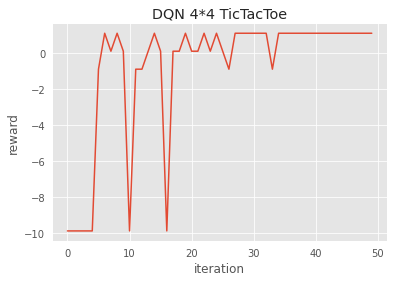

In [19]:
def show_rewards(avg_rewards):
    iterations=np.arange(0, len(avg_rewards))
    fig, ax = plt.subplots(1, 1)
    ax.plot(iterations, avg_rewards)
    ax.set_xlabel('iteration')
    ax.set_ylabel('reward')
    _ = ax.set_title('DQN 4*4 TicTacToe')

show_rewards(rewards)

In [23]:
GAMMA = 0.99
INITIAL_STEPS = 1024
TRANSITIONS = 500000
STEPS_PER_UPDATE = 4
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000
BATCH_SIZE = 64
LEARNING_RATE = 5e-4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class DDQN:
    def __init__(self, state_dim, action_dim, batch_size=BATCH_SIZE, seed=0):
        self.steps = 0 # Do not change        
        self.buffer = ExpirienceReplay()
        self.batch_size = batch_size        
        self.seed = random.seed(seed)
        
        self.model = DQNModel(state_dim, 64, action_dim)
        self.model_target = DQNModel(state_dim, 64, action_dim)
        self.optimizer = Adam(self.model.parameters())

    def get_model(self):
        return self.model

    def consume_transition(self, transition):        
        self.buffer.add(transition)

    def sample_batch(self):
        return self.buffer.sample(self.batch_size)
        
    def train_step(self, batch):
        states, actions, rewards, next_states, dones = batch
        # Get the action with max Q value
        action_values = self.model_target(next_states).detach()
        # Notes
        # tensor.max(1)[0] returns the values, tensor.max(1)[1] will return indices
        # unsqueeze operation --> np.reshape
        # Here, we make it from torch.Size([64]) -> torch.Size([64, 1])
        max_action_values = action_values.max(1)[0].unsqueeze(1)
        
        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (GAMMA * max_action_values * (1 - dones))
        Q_expected = self.model(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()
        
        # Update fixed weights
        self.update_target_network()
        
    def update_target_network(self):
        # Update weights of a target Q-network here. You may use copy.deepcopy to do this or 
        # assign a values of network parameters via PyTorch methods.
        self.model_target = copy.deepcopy(self.model)

    def act(self, state):
        # Compute an action. Do not forget to turn state to a Tensor and then turn an action to a numpy array.
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.model.eval()
        with torch.no_grad():
            action_values = self.model(state)
        self.model.train()
        return np.argmax(action_values.cpu().data.numpy())
            
        
    def update(self, transition):
        # You don't need to change this
        self.consume_transition(transition)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch()
            self.train_step(batch)
        if self.steps % STEPS_PER_TARGET_UPDATE == 0:
            self.update_target_network()
        self.steps += 1

    def save(self):
        torch.save(self.model.state_dict(), "agent.pkl")



In [21]:
def train_ddqn():
    env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
    eps = 0.01
    env.reset()
    dqn = DDQN(state_dim=4*4, action_dim=4*4)
    state = state_to_array(env.getHash())
    total_rewards = []


    for _ in range(INITIAL_STEPS):
        # action = env.action_space.sample()
        picked_action, action_idx = sample_action(env)

        # next_state, reward, done, _ = env.step(action)
        next_state, reward, done, _ = env.step(picked_action)
        
        next_state = state_to_array(next_state[0])
        
        dqn.consume_transition(Transition(state, action_idx, next_state, reward, done)  )
          
        if not done:
            state = next_state 
        else:
            env.reset()
            state = state_to_array(env.getHash())
        

    for i in range(TRANSITIONS):
        #Epsilon-greedy policy
        if random.random() < eps:
            action, action_idx = sample_action(env)
        else:
            action_idx = dqn.act(state)
            action = env.action_from_int(action_idx)

        next_state, reward, done, _ = env.step(action)
        next_state = state_to_array(next_state[0])
        dqn.update(Transition(state, action_idx, next_state, reward, done))
        
        if not done:
            state = next_state 
        else:
            env.reset()
            state = state_to_array(env.getHash())
        
        if (i + 1) % (TRANSITIONS//50) == 0:
            rewards = evaluate_policy(dqn, env, 30)
            total_rewards.append(np.mean(rewards))
            print(f"Step: {i+1}, Reward mean: {np.mean(rewards)}, Reward std: {np.std(rewards)}")
    return total_rewards

In [24]:
rewards = train_ddqn()

Step: 10000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 20000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 30000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 40000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 50000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 60000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 70000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 80000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 90000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 100000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 110000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 120000, Reward mean: -9.899999999999999, Reward std: 1.7763568394002505e-15
Step: 130000, Reward mean

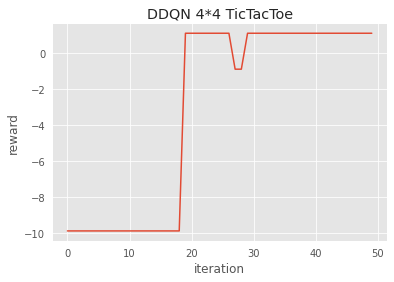

In [25]:
def show_rewards(avg_rewards):
    iterations=np.arange(0, len(avg_rewards))
    fig, ax = plt.subplots(1, 1)
    ax.plot(iterations, avg_rewards)
    ax.set_xlabel('iteration')
    ax.set_ylabel('reward')
    _ = ax.set_title('DDQN 4*4 TicTacToe')

show_rewards(rewards)

Как можно видеть, double DQN сходится быстрее, обучается стабильнее, но поначалу тоже имеются скачки.

# Часть третья: расширим и углубим поиск #
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.


1. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).
2. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.


Источник: 
https://gist.github.com/qpwo/c538c6f73727e254fdc7fab81024f6e1

In [27]:
class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)


    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def do_rollout_with_reward(self, node):
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)
        return reward

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            unexplored = self.children[node] - self.children.keys()
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        invert_reward = False
        while True:
            if node.is_terminal():
                reward = node.reward()
                return 1 - reward if invert_reward else reward
            node = node.find_random_child()
            invert_reward = not invert_reward

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = 1 - reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

    @abstractmethod
    def reward(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        return 0

    @abstractmethod
    def __hash__(self):
        "Nodes must be hashable"
        return 123456789

    @abstractmethod
    def __eq__(node1, node2):
        "Nodes must be comparable"
        return True

In [28]:
from collections import namedtuple
from random import choice

_TTTB = namedtuple("TicTacToeBoard", "tup turn winner terminal")

# Inheriting from a namedtuple is convenient because it makes the class
# immutable and predefines __init__, __repr__, __hash__, __eq__, and others
class TicTacToeBoard(_TTTB, Node):

    def find_children(board):
        if board.terminal:  # If the game is finished then no moves can be made
            return set()
        # Otherwise, you can make a move in each of the empty spots
        return {
            board.make_move(i) for i, value in enumerate(board.tup) if value is None
        }


    def find_random_child(board):
        if board.terminal:
            return None  # If the game is finished then no moves can be made
        empty_spots = [i for i, value in enumerate(board.tup) if value is None]
        return board.make_move(choice(empty_spots))

    def reward(board):
        if board.winner == True:
            return -10 # MCTS lost
        elif board.winner == None:
            return 0.5
        else:
            return 1  # MCTS won

    def is_terminal(board):
        return board.terminal

    def make_move(board, index):
        tup = board.tup[:index] + (board.turn,) + board.tup[index + 1 :]
        turn = not board.turn
        winner = _find_winner(tup)
        is_terminal = (winner is not None) or not any(v is None for v in tup)
        return TicTacToeBoard(tup, turn, winner, is_terminal)


def play_game(rollouts=50):
    tree = MCTS()
    board = new_tic_tac_toe_board()
    while True:
        empty_spots = [i for i, value in enumerate(board.tup) if value is None]
        index = choice(empty_spots)
        board = board.make_move(index)
        if board.terminal:
            break
        # You can train as you go, or only at the beginning.
        # Here, we train as we go, doing fifty rollouts each turn.
        for _ in range(rollouts):
            tree.do_rollout(board)
        board = tree.choose(board)
        if board.terminal:
            break
    return board.reward()


def get_rollout_rewards(rollouts=50):
    tree = MCTS()
    board = new_tic_tac_toe_board()
    rollout_results = []
    for _ in range(rollouts):
        rollout_results.append(tree.do_rollout_with_reward(board))
    return rollout_results


def simulate(episodes=50, rollouts=50):
    rewards = []
    for _ in range(episodes):
        rewards.append(play_game(rollouts))
    
    return np.mean(np.array(rewards))


def _winning_combos():
    for start in range(0, 16, 4):  # four in a row
        yield (start, start + 1, start + 2, start + 3)
    for start in range(4):  # four in a column
        yield (start, start + 4, start + 8, start + 12)
    yield (0, 5, 10, 15)  # down-right diagonal
    yield (3, 6, 9, 12)  # down-left diagonal


def _find_winner(tup):
    "Returns None if no winner, True if X wins, False if O wins"
    for i1, i2, i3, i4 in _winning_combos():
        v1, v2, v3, v4 = tup[i1], tup[i2], tup[i3], tup[i4]
        if False is v1 is v2 is v3 is v4:
            return False
        if True is v1 is v2 is v3 is v4:
            return True
    return None


def new_tic_tac_toe_board():
    return TicTacToeBoard(tup=(None,) * 16, turn=True, winner=None, terminal=False)   

In [30]:
rewards = []

for _ in range(100):
    rewards.append(np.mean(np.array(get_rollout_rewards(rollouts=25))))

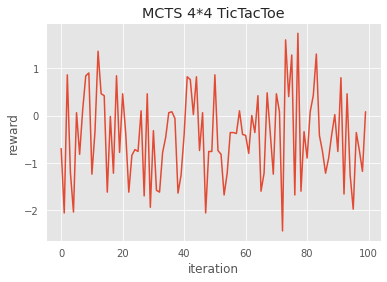

In [31]:
def show_rewards(avg_rewards):
    iterations=np.arange(0, len(avg_rewards))
    fig, ax = plt.subplots(1, 1)
    ax.plot(iterations, avg_rewards)
    ax.set_xlabel('iteration')
    ax.set_ylabel('reward')
    _ = ax.set_title('MCTS 4*4 TicTacToe')

show_rewards(rewards)

In [33]:
def _winning_combos():
    for start in range(0, 9, 3):  # three in a row
        yield (start, start + 1, start + 2)
    for start in range(3):  # three in a column
        yield (start, start + 3, start + 6)
    yield (0, 4, 8)  # down-right diagonal
    yield (2, 4, 6)  # down-left diagonal


def _find_winner(tup):
    "Returns None if no winner, True if X wins, False if O wins"
    for i1, i2, i3 in _winning_combos():
        v1, v2, v3 = tup[i1], tup[i2], tup[i3]
        if False is v1 is v2 is v3:
            return False
        if True is v1 is v2 is v3:
            return True
    return None


def new_tic_tac_toe_board():
    return TicTacToeBoard(tup=(None,) * 9, turn=True, winner=None, terminal=False)

In [34]:
rewards = []

for _ in range(100):
    rewards.append(np.mean(np.array(get_rollout_rewards(rollouts=25))))

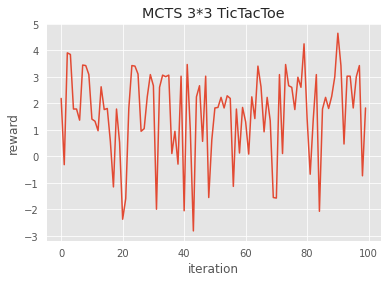

In [35]:
def show_rewards(avg_rewards):
    iterations=np.arange(0, len(avg_rewards))
    fig, ax = plt.subplots(1, 1)
    ax.plot(iterations, avg_rewards)
    ax.set_xlabel('iteration')
    ax.set_ylabel('reward')
    _ = ax.set_title('MCTS 3*3 TicTacToe')

show_rewards(rewards)

Попробуем добавить стратегию из DDQN 

In [41]:
TRANSITIONS = 200000

def train_ddqn():
    env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
    eps = 0.01
    env.reset()
    dqn = DDQN(state_dim=3*3, action_dim=3*3)
    state = state_to_array(env.getHash())
    total_rewards = []


    for _ in range(INITIAL_STEPS):
        # action = env.action_space.sample()
        picked_action, action_idx = sample_action(env)

        # next_state, reward, done, _ = env.step(action)
        next_state, reward, done, _ = env.step(picked_action)
        
        next_state = state_to_array(next_state[0])
        
        dqn.consume_transition(Transition(state, action_idx, next_state, reward, done)  )
          
        if not done:
            state = next_state 
        else:
            env.reset()
            state = state_to_array(env.getHash())
        

    for i in range(TRANSITIONS):
        #Epsilon-greedy policy
        if random.random() < eps:
            action, action_idx = sample_action(env)
        else:
            action_idx = dqn.act(state)
            action = env.action_from_int(action_idx)

        next_state, reward, done, _ = env.step(action)
        next_state = state_to_array(next_state[0])
        dqn.update(Transition(state, action_idx, next_state, reward, done))
        
        if not done:
            state = next_state 
        else:
            env.reset()
            state = state_to_array(env.getHash())
        
        if (i + 1) % (TRANSITIONS//10) == 0:
            rewards = evaluate_policy(dqn, env, 30)
            total_rewards.append(np.mean(rewards))
            print(f"Step: {i+1}, Reward mean: {np.mean(rewards)}, Reward std: {np.std(rewards)}")
    return dqn.get_model()

model = train_ddqn()

Step: 20000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16
Step: 40000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16
Step: 60000, Reward mean: -0.8999999999999998, Reward std: 2.220446049250313e-16
Step: 80000, Reward mean: 0.10000000000000003, Reward std: 2.7755575615628914e-17
Step: 100000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16
Step: 120000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16
Step: 140000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16
Step: 160000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16
Step: 180000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16
Step: 200000, Reward mean: 1.1000000000000003, Reward std: 2.220446049250313e-16


In [43]:
def act(model, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)    
    with torch.no_grad():
        action_values = self.model(state)    
    return np.argmax(action_values.cpu().data.numpy())

In [44]:
def play_game(rollouts=50):
    tree = MCTS()
    board = new_tic_tac_toe_board()
    while True:
        empty_spots = [i for i, value in enumerate(board.tup) if value is None]
        index = act(model, empty_spots)
        board = board.make_move(index)
        if board.terminal:
            break
        # You can train as you go, or only at the beginning.
        # Here, we train as we go, doing fifty rollouts each turn.
        for _ in range(rollouts):
            tree.do_rollout(board)
        board = tree.choose(board)
        if board.terminal:
            break
    return board.reward()

In [52]:
rewards = []

for _ in range(100):
    rewards.append(np.mean(np.array(get_rollout_rewards(rollouts=25))))

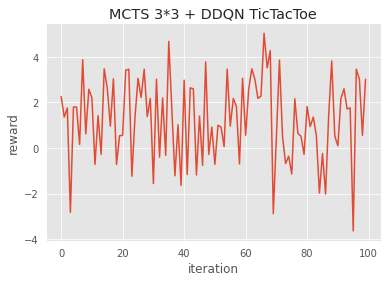

In [53]:
def show_rewards(avg_rewards):
    iterations=np.arange(0, len(avg_rewards))
    fig, ax = plt.subplots(1, 1)
    ax.plot(iterations, avg_rewards)
    ax.set_xlabel('iteration')
    ax.set_ylabel('reward')
    _ = ax.set_title('MCTS 3*3 + DDQN TicTacToe')

show_rewards(rewards)

Результат ожидаемо получился лучше.